In [1]:
!pip install ultralytics
import os 
os.environ['WANDB_MODE'] = 'disabled'
os.environ['WANDB_DISABLED'] = 'true'

from ultralytics import YOLO, settings
settings.update({"wandb": False})

TRAINING_SESSION = True

IMG_RESIZE=(416,416)

DATASET_SELECTION = 'axial'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 21.2 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
import pydicom
import numpy as np
import torch

## TRAIN

In [ ]:
# Load a model, yolov8m.pt
model = YOLO("yolov8m.pt")  # load a pretrained model (recommended for training) 

# Train the model
results = model.train(data=f"/kaggle/input/rsna-2024-yolo/data_{DATASET_SELECTION}.yaml", 
                      epochs=30, 
                      imgsz=IMG_RESIZE[0], 
                      patience=3,
                      device=0,
                      cls=2
#                       project=
#                       name=
                     )

In [ ]:
if TRAINING_SESSION:
    exit()

## Investigate Training Data

In [3]:
import glob
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pydicom
import functools

TRAIN_IMAGE_DIR = "/kaggle/input/rsna-2024-yolo/yolo_sagittal/images/train/"
TRAIN_LABEL_DIR = "/kaggle/input/rsna-2024-yolo/yolo_sagittal/labels/train/"

LUMBAR_LABEL_MAPPING = {"l1_l2":0,"l2_l3":1,"l3_l4":2,"l4_l5":3,"l5_s1":4}

image_dir = glob.glob(f"{TRAIN_IMAGE_DIR}/1777645381_1438513204*")
label_dir = glob.glob(f"{TRAIN_LABEL_DIR}/1777645381_1438513204*")

In [4]:
@functools.lru_cache(1, typed=True)
def get_image(path):
    return pydicom.dcmread(path)

In [5]:
def scale_xy(bbox_xyxy: np.array, original_w_h=(), new_w_h=()):    
    # Original image size
    original_width = original_w_h[0]
    original_height = original_w_h[1]

    # Resized image size
    resized_width = new_w_h[0]
    resized_height = new_w_h[1]

    # Scaling factors
    scale_x = original_width / resized_width
    scale_y = original_height / resized_height

    # Upscale the bounding box coordinates to the original image size
    bbox_original = bbox_xyxy * np.array([scale_x, scale_y, scale_x, scale_y])

    # bbox_original now contains the upscaled coordinates
    x1_upscaled, y1_upscaled, x2_upscaled, y2_upscaled = bbox_original
    
    return (int(x1_upscaled), int(y1_upscaled), int(x2_upscaled), int(y2_upscaled))

In [6]:
import pandas as pd
train_desc = pd.read_csv("/kaggle/input/rsna-2024-train/train_candidates.csv")

In [17]:
studyid_seriesid = train_desc[['study_id','series_id']].to_dict(orient='records')

In [ ]:
examples = studyid_seriesid[0:5]

In [8]:
train_desc_dict = train_desc.loc[(train_desc.study_id == 1777645381) & (train_desc.series_id == 1438513204)].sort_values('series_id').to_dict(orient='records')

In [46]:
def read_and_plot(study_id: int, series_id: int):

    train_desc_dict = train_desc.loc[(train_desc.study_id == study_id) & (train_desc.series_id == series_id)].sort_values('series_id').to_dict(orient='records')
    
    for i in train_desc_dict:

        img_path = f"{i['folder_path']}/{i['series_id']}/{int(i['instance_number'])}.dcm"
        img_t = get_image(img_path)
    
        xyxy = (i['x'], i['y'], 0, 0)
        
        x, y, _, _ = scale_xy(xyxy, original_w_h=IMG_RESIZE, new_w_h=(img_t.Rows, img_t.Columns))
        
        i.update({'rescale_centres': (x,y)})

    img_path = glob.glob(f"{TRAIN_IMAGE_DIR}/{study_id}_{series_id}*")[0]
    label_path = glob.glob(f"{TRAIN_LABEL_DIR}/{study_id}_{series_id}*")[0]
        
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    from pathlib import Path
    
    label_str = Path(label_path).read_text()
    
    box_list = [tuple(i.split(" ")) for i in label_str.split("\n\n")][0:5] # len of classes
    box_list = box_list[0:len(box_list)-1]
    
    gt_boxes = [tuple(float(x) for x in y) for y in box_list]

    
    scale_factor = IMG_RESIZE[0]
    # Create a figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(img)
    
    # Plot ground truth boxes
    for box in gt_boxes:
        cls, x_center, y_center, width, height = box
        
        # Scale the coordinates
        x_center_scaled = x_center * scale_factor
        y_center_scaled = y_center * scale_factor
        width_scaled = width * scale_factor
        height_scaled = height * scale_factor
    
        # Calculate the top-left corner of the bounding box
        x_min = x_center_scaled - (width_scaled / 2)
        y_min = y_center_scaled - (height_scaled / 2)
    
        x_point, y_point = [i for i in train_desc_dict if LUMBAR_LABEL_MAPPING[i['level']] == cls][0]['rescale_centres']
        
        ax.plot(x_point, y_point, 'ro', markersize=5)  # 'ro' is a red dot; adjust markersize as needed
    
        
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min), 
            width_scaled, 
            height_scaled, 
            linewidth=2, 
            edgecolor='green', 
            facecolor='none'
        )
    
        # Add the rectangle to the axes
        ax.add_patch(rect)
    
    # Optionally, add class labels
        ax.text(
            x_min, y_min - 5,  # Position the text slightly above the box
            cls, 
            fontsize=12, 
            color='yellow', 
            backgroundcolor='black'
        )
    
    # Show the plot
    plt.show()

In [34]:
study_id=1777645381
series_id=1438513204

image_dir = glob.glob(f"{TRAIN_IMAGE_DIR}/{study_id}_{series_id}*")[0]
label_dir = glob.glob(f"{TRAIN_LABEL_DIR}/{study_id}_{series_id}*")[0]

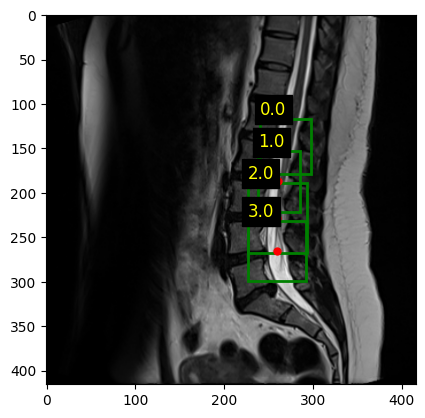

In [47]:
read_and_plot(1777645381,1438513204)

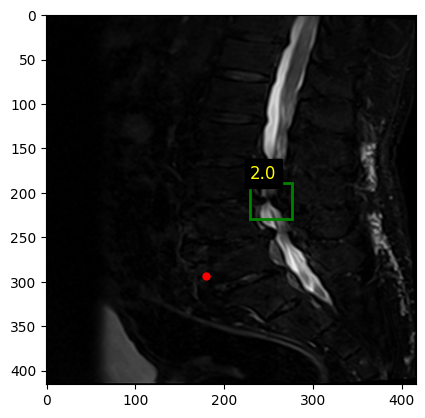

In [58]:
eg = studyid_seriesid[1]
study_id = eg['study_id']
series_id = eg['series_id']
read_and_plot(study_id,series_id)

In [ ]:
# get image path
# get image for rows/columns resizing
# scale x and y
# transform class
# plot centres

In [60]:
xyxy

(259.02624446440507, 370.8288770053476, 0, 0)

In [ ]:
train_desc_dict

In [59]:
train_desc_dict = train_desc.loc[(train_desc.study_id == study_id) & (train_desc.series_id == series_id)].sort_values('series_id').to_dict(orient='records')

for i in train_desc_dict:

    img_path = f"{i['folder_path']}/{i['series_id']}/{int(i['instance_number'])}.dcm"
    img_t = get_image(img_path)

    xyxy = (i['x'], i['y'], 0, 0)
    
    x, y, _, _ = scale_xy(xyxy, original_w_h=IMG_RESIZE, new_w_h=(img_t.Rows, img_t.Columns))
    
    i.update({'rescale_centres': (x,y)})

img_path = glob.glob(f"{TRAIN_IMAGE_DIR}/{study_id}_{series_id}*")[0]
label_path = glob.glob(f"{TRAIN_LABEL_DIR}/{study_id}_{series_id}*")[0]

In [ ]:

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

from pathlib import Path

label_str = Path(label_path).read_text()

box_list = [tuple(i.split(" ")) for i in label_str.split("\n\n")][0:5] # len of classes

gt_boxes = [tuple(float(x) for x in y) for y in box_list]

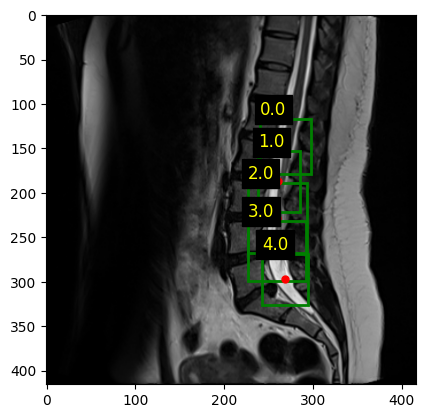

In [14]:
scale_factor = IMG_RESIZE[0]
# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Plot ground truth boxes
for box in gt_boxes:
    cls, x_center, y_center, width, height = box
    
    # Scale the coordinates
    x_center_scaled = x_center * scale_factor
    y_center_scaled = y_center * scale_factor
    width_scaled = width * scale_factor
    height_scaled = height * scale_factor

    # Calculate the top-left corner of the bounding box
    x_min = x_center_scaled - (width_scaled / 2)
    y_min = y_center_scaled - (height_scaled / 2)

    x_point, y_point = [i for i in train_desc_dict if LUMBAR_LABEL_MAPPING[i['level']] == cls][0]['rescale_centres']
    
    ax.plot(x_point, y_point, 'ro', markersize=5)  # 'ro' is a red dot; adjust markersize as needed

    
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), 
        width_scaled, 
        height_scaled, 
        linewidth=2, 
        edgecolor='green', 
        facecolor='none'
    )

    # Add the rectangle to the axes
    ax.add_patch(rect)

# Optionally, add class labels
    ax.text(
        x_min, y_min - 5,  # Position the text slightly above the box
        cls, 
        fontsize=12, 
        color='yellow', 
        backgroundcolor='black'
    )

# Show the plot
plt.show()

In [ ]:
results_out = model.val()

In [ ]:
results_out.process

In [ ]:
dir(results_out)

### Inference

In [ ]:
MODEL_DIR = "/kaggle/input/rsna-yolo-v1/pytorch/best_20240716/1/best_20240716.pt"
IMAGE_DIR = "/kaggle/input/rsna-2024-yolo/yolo_test_sample/images/sample/"
process_test = False

In [ ]:
import glob
# Load a model
model = YOLO(MODEL_DIR)  # pretrained YOLOv8n model

# Run batched inference on a list of images
files_for_inference = sorted(glob.glob(f"{IMAGE_DIR}*"))
results = model(files_for_inference,task='detect',iou=0.8)  # return a list of Results objects

if process_test:
    # Process results list
    for result in results:
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        obb = result.obb  # Oriented boxes object for OBB outputs
    #     result.show()  # display to screen
        path = result.path.split("/")[-1].replace(".png","")
        if result.boxes:
            result.save(filename=f"{path}_result.jpg")  # save to disk

In [ ]:
files_for_inference

In [ ]:
# TODO - re-update data and read in meta/study_id_meta.pickle file instead
study_id_meta = {105895264: {'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/105895264',
  'series_id_files': ['1073066831', '1796707037', '1873322271', '3528018752'],
  'series_descriptions': ['Sagittal T2/STIR',
   'Axial T2',
   'Axial T2',
   'Sagittal T1']},
 1018005303: {'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1018005303',
  'series_id_files': ['1049505285',
   '1131788901',
   '3398516088',
   '3675524442',
   '4193900495'],
  'series_descriptions': ['Axial T2',
   'Sagittal T2/STIR',
   'Sagittal T1',
   'Axial T2',
   'Axial T2']},
 1019430579: {'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1019430579',
  'series_id_files': ['2116282832', '3087919501', '4056780644'],
  'series_descriptions': ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']}}

In [ ]:
import re
def clean_newlines(input_string):
    # Replace multiple newlines with a single newline
    cleaned_string = re.sub(r'\n+', '\n', input_string)
    # If there are newlines at the end, remove them
    cleaned_string = re.sub(r'\n+$', '', cleaned_string)
    return cleaned_string.split("\n")

In [ ]:
# Function to extract the numeric values from the filename
def extract_numbers(file_path):
    filename = file_path.split('/')[-1]
    numbers = re.findall(r'\d+', filename)
    return list(map(int, numbers))


In [ ]:
import functools
@functools.lru_cache(1, typed=True)
def get_image(path):
    return pydicom.dcmread(path)

### Plotting ground boxes (ground truth vs. predicted)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import glob
import math

def plot_yolo_predictions_and_ground_truth(image_dir, label_dir, model, pattern="*", label_paths=[], results = None):
    """
    Plot YOLO predictions and ground truth labels on images.

    Parameters:
    - image_dir (str): Directory containing the images.
    - label_dir (str): Directory containing the label files.
    - model: YOLO model for making predictions.
    - pattern (str): Pattern to match image files in the directory.
    """
    # Get list of images
    image_paths = sorted(glob.glob(os.path.join(image_dir, pattern)),key=extract_numbers)
    
    if not results:
        # Run batch inference
        results = model(image_paths)

    # Plot image with ground truth and predicted boxes
    num_rows = math.ceil(len(image_paths)/4)
    fig, ax = plt.subplots(num_rows, 4, figsize=(16, 16))      
    
    if num_rows > 1:
        ax = ax.flatten()
    else:
        ax = [ax]  # Make it iterable for consistency    
    
    imgs = []
    for i, image_path in enumerate(image_paths):
        # Load image
        img = cv2.imread(image_path)
        imgs.append(img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get corresponding label file
        if label_paths:
            label_path = label_paths[image_path]
        else:
            label_path = os.path.join(label_dir, os.path.basename(image_path).replace('.png', '.txt'))
        
        if os.path.exists(label_path):
            # Read ground truth labels
            with open(label_path, 'r') as f:
                gt_labels = f.read()

            gt_labels = clean_newlines(gt_labels)

            # Convert ground truth labels to bounding boxes
            gt_boxes = []
            if gt_labels:
                for label in gt_labels:
                    cls, x, y, w, h = map(float, label.strip().split())
                    x_min = int((x - w / 2) * img.shape[1])
                    y_min = int((y - h / 2) * img.shape[0])
                    x_max = int((x + w / 2) * img.shape[1])
                    y_max = int((y + h / 2) * img.shape[0])
                    gt_boxes.append([x_min, y_min, x_max, y_max, int(cls)])
        else:
            gt_boxes = []
        
        # Get prediction results for the current image
        result = results[i]
        pred_boxes = result.boxes.xyxy.cpu().numpy()  # Convert to numpy array
        pred_cls = result.boxes.cls.cpu().numpy()
        pred_conf = result.boxes.conf.cpu().numpy()
        
        ax[i].imshow(img_rgb)
        
        # Plot ground truth boxes
        for box in gt_boxes:
            x_min, y_min, x_max, y_max, cls = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='green', linewidth=2)
            ax[i].add_patch(rect)
            ax[i].text(x_min, y_min - 2, f'GT {cls}', fontsize=12, color='green')
        
        # Plot predicted boxes
        for box, cls, conf in zip(pred_boxes, pred_cls, pred_conf):
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
            ax[i].add_patch(rect)
            ax[i].text(x_min, y_min - 2, f'Pred {cls:.0f} ({conf:.2f})', fontsize=12, color='red')
        
    # Show the result
    plt.show()
        
    return results, imgs


In [ ]:
model = YOLO(MODEL_DIR)
STUDY_ID = 105895264 # 1018005303 1019430579 105895264

results, imgs = plot_yolo_predictions_and_ground_truth(
    image_dir="/kaggle/input/rsna-2024-yolo/yolo_test_sample/images/sample",
    label_dir="/kaggle/input/rsna-2024-yolo/yolo_zip/labels/val",
    model=model,
    pattern=f"{STUDY_ID}*"
)
